# Final project - Bunny ecosystem simulation

    Name: Clara Periago
    Student #: s1067476

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

import fastplotlib as fpl

import seaborn as sns
import plot
import grid
from result import Result

sns.set_context("talk")

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),Apple M3 Max,IntegratedGPU,Metal,


In [2]:
# diffusion coefficients
dK = jnp.array([1.0, 0.5, 0.5])
dt = 1.
t = jnp.arange(0, 1000, dt)

# result flat, 1 bunny
r1flat = Result(
    dK,
    dt,
    max_ns=1,
    flat_terrain=True
)
# result mountain 1 bunny
r1 = Result(
    dK,
    dt,
    max_ns=1,
)
# result flat 2 bunny
r2flat = Result(
    dK,
    dt,
    flat_terrain=True
)
# result mountain 2 bunny
r2 = Result(
    dK,
    dt,
)
# result mountain 2 bunny mixed 0.05
r2mix = Result(
    dK,
    dt,
    grass_consumption=jnp.array([.5, .5]),
    mix_eps=0.05
)
# list of result, snapshot times
# how long & when to snapshot each one
#  was determined empirically with the interactive viewer
all_results = [
    (r1flat, jnp.array([0, 25, 50, 75, 200])),
    (r1, jnp.array([0, 50, 150, 500, 750])),
    (r2flat, jnp.array([0, 25, 50, 75, 200])),
    (r2, jnp.array([0, 50, 150, 500, 750])),
    (r2mix, jnp.array([0, 50, 150, 500, 1000])),
]

In [3]:
def plot_progression(frames, indices, name, terrain_contours=[]):
    ncols = len(frames)
    fig, axs = plt.subplots(figsize=(8, 8), ncols=ncols, layout='constrained')
        
    for i, (r, idx) in enumerate(zip(frames, indices)):
        axs[i].imshow(r)
        axs[i].axis("off")
        axs[i].set_title(f"step={idx}")
    
    if len(terrain_contours) > 0:
        ax = axs[-1]
        ax.imshow(frames[-1])
        plot.overlay_terrain_contours(terrain_contours, ax, lw=.3)
        ax.axis("off")
        ax.set_title(f"step={idx}\n+terrain")
    
    plot.save_figure(fig, name)

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/320x320_b1_flat_progression.png


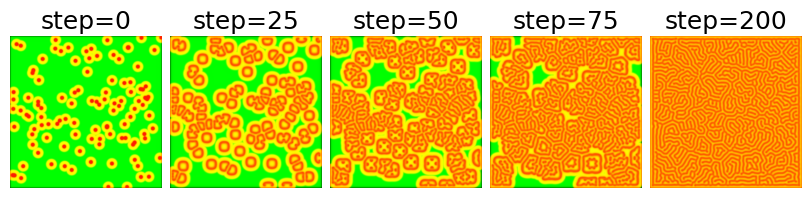

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/320x320_b1_progression.png


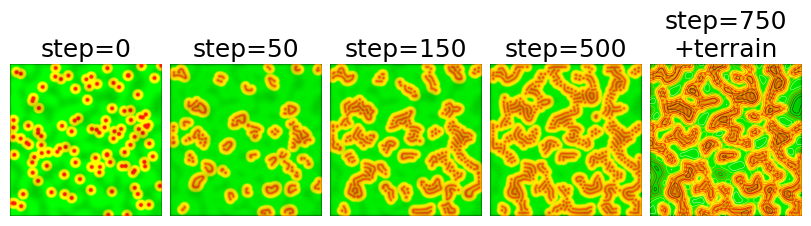

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/320x320_b2_flat_progression.png


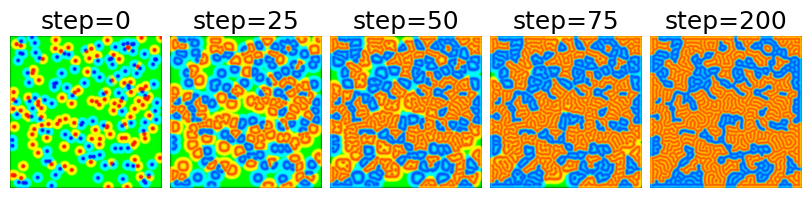

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/320x320_b2_progression.png


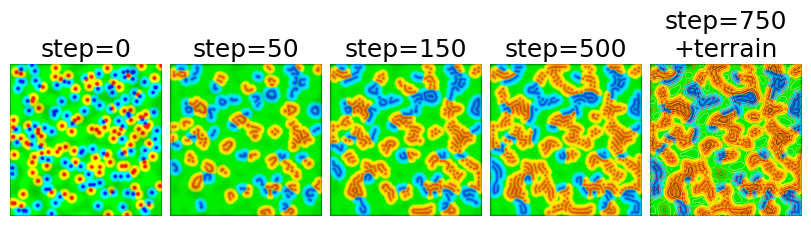

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/320x320_b2_mix_progression.png


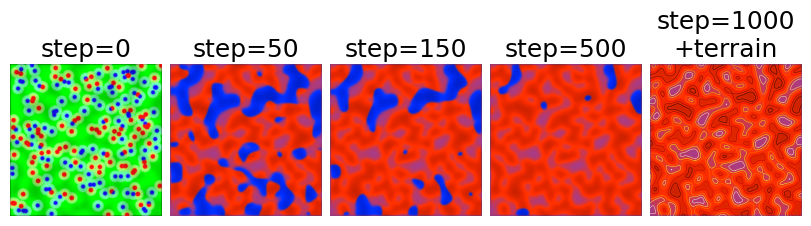

In [4]:
for rr, snaps in all_results:
    mx = snaps[-1]
    xs, xs_history = rr.simulate(max_steps=mx)
    
    cmap = None
    to_snap = xs_history[snaps]
    rgbs = jax.vmap(plot.render_frame, (0, None, None))(to_snap, rr.heightmap, cmap)

    plot_progression(
        rgbs,
        snaps,
        name=f"{rr._fmt_()}_progression.png",
        terrain_contours=rr.contours
    )
    plt.show()
    # break

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/s0.png


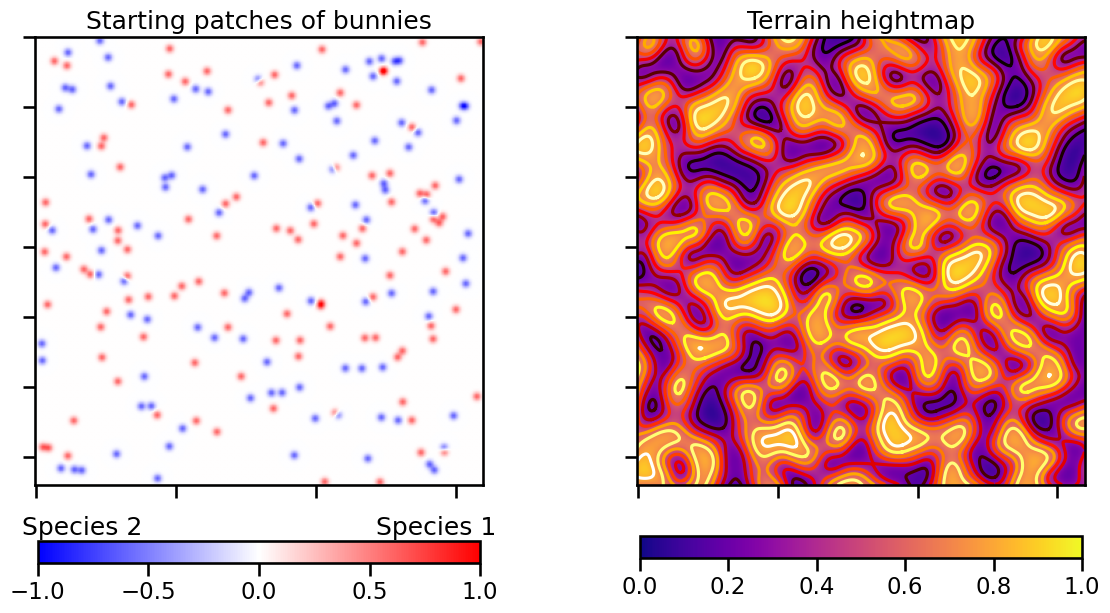

In [5]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(12, 6), ncols=2,
    sharey=True,
    sharex=True,
    layout='constrained'
)

ima = ax1.imshow(r2.s0[1]-r2.s0[2], cmap='bwr', vmin=-1., vmax=1.)
cba = plt.colorbar(ima, shrink=.75, orientation="horizontal", pad=0.035)
cba.ax.text(.8, 1.6, 'Species 1', ha='center', va='center')
cba.ax.text(-.8, 1.6, 'Species 2', ha='center', va='center')
ax1.set_title('Starting patches of bunnies')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
# ax1.axis("off")

imb = ax2.imshow(r2.heightmap, cmap="plasma", vmin=0., vmax=1.)
plot.overlay_terrain_contours(rr.contours, ax2)

cbb = plt.colorbar(imb, shrink=.75, orientation="horizontal", pad=0.03)
cbb.ax.text(0., 1.5, ' ', ha='center', va='center') # otherwise the colorbars are not aligned
ax2.set_title('Terrain heightmap')
# ax2.axis("off")
plot.save_figure(fig, 's0.png')

## Interactive simulation

This was super helpful when developing, since we don't need to wait for the result of `lax.scan`. Since we don't care about intermediate values, we can just display and remove them from memory.

In [ ]:
marker_index = 0

# select the result!!
# t toggles the terrain overlay
# s takes a screenshot
# left/right click creates a bunny patch at the cursor
rr = r2mix
current_x = rr.s0

fig = fpl.Figure(size=(600, 600))
fig.canvas.max_buffered_frames = 1

fig[0, 0].title = "Bunny simulation"
lc = fig[0, 0].add_line_collection(
    data=rr.contours,
    colors=(0, 0, 0, 0.25),  # translucent black
    cmap="plasma",
    thickness=1.4,
)
lc.visible = False

data = jnp.zeros((320, 320, 3))
image = fig[0, 0].add_image(
    data=data,
    name="random-image",
    # cmap="Spectral",
    vmin=0.,
    vmax=1.,
    # offset=(0., 0., 2.),
)
cmap = plt.colormaps.get_cmap("Spectral")

fig[0, 0].add_text(text="0", name="frame", offset=(-50, 40, 0))
fig[0, 0].add_text(text="0", name="max_G", offset=(-50, 60, 0))
for i in range(rr.nS):
    fig[0, 0].add_text(text="0", name=f"max_B{i+1}", offset=(-50, 80+i*20, 0))

def update_data():
    global marker_index, current_x
    marker_index += 1

    if marker_index >= 3000:
        marker_index = 0
        current_x = rr.s0

    current_x, _ = rr.stepper(current_x)
    x = jnp.clip(current_x, 0, 1)
    grass = x[0]
    bunnies = x[1:]
    rgb = plot.render_frame(x, rr.heightmap) / 255.
    
    fig[0, 0]["random-image"].data = rgb
    fig[0, 0]["frame"].text = f"frame={marker_index}"
    fig[0, 0]["max_G"].text = f"max_A={jnp.max(grass):.3f}"
    for i in range(rr.nS):
        fig[0, 0][f"max_B{i+1}"].text = f"max_B{i+1}={jnp.max(bunnies[i]):.3f}"

@fig.renderer.add_event_handler("key_down")
def toggle(ev):
    if ev.key == "t":
        for g in fig[0, 0].graphics:
            if isinstance(g, fpl.LineGraphic) or isinstance(g, fpl.LineCollection):
                g.visible = not g.visible
    if ev.key == "s":
        tt = ['max_G', 'max_B1', 'max_B2', 'frame']
        def toggle(v):
            for g in fig[0, 0].graphics:
                print(g.name)
                if g.name in tt:
                    g.visible = v
        toggle(False)
        fig.export(f'./out/pics/{marker_index}.png')
        toggle(True)

@image.add_event_handler("pointer_down")
def click_event(ev):
    global current_x
    # get the click location in screen coordinates
    xy = (ev.x, ev.y)
    ev.stop_propagation()

    # map the screen coordinates to world coordinates
    xy = fig[0, 0].map_screen_to_world(xy)[:-1]
    y, x = jnp.array(xy, dtype=int)

    # print the click location
    ch = ev.button
    current_x = grid.draw_circle(current_x, x, y, 2, .3, channel=ch)
    print(x, y)

fig.add_animations(update_data)

# show the plot
fig.show()